# **Africa Conflict Risk Prediction Model**

This notebook is part of my machine learning  AI-driven model to predict, analyze, and localize conflict risks across Africa. Built for government and professional use.

## **Objectives**

Load and explore a rich ACLED-style dataset of conflict events.

Professionally select features important to geopolitical intelligence.

Preprocess and clean the data.

Engineer a binary risk label based on fatalities.

Train a machine learning model to predict high-risk conflict events.

Evaluate model performance.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import joblib

In [3]:
# Load data
df = pd.read_csv("Conflicts-afri_datahome - data_set-conflict (1).csv", low_memory=False)

In [16]:
df.head()

,GWNO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,ACTOR1,ALLY_ACTOR_1,INTER1,...,ADMIN1,ADMIN2,ADMIN3,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,NOTES,FATALITIES
0,615,16ALG,16,1997-02-01,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,Bordj Bou Arreridj,Tixter,NaN,Mechta Larbaa,36.0466,5.1317,1.0,www.algeria-watch.org,1 February: 7 citizens of a farming estate (Ha...,7.0
1,615,39ALG,39,1997-06-02,1997,1,Remote violence,GIA: Armed Islamic Group,NaN,2,...,Alger,Sidi MHamed,NaN,Algiers,36.7525,3.0420,1.0,www.algeria-watch.org,2 June: Explosion of a bomb in the working-cla...,10.0
2,615,45ALG,45,1997-07-02,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,Mascara,Benian,NaN,Chabet Larbaa,35.0961,0.2078,1.0,www.algeria-watch.org,2 July: 4 people of the same family were kille...,4.0
3,615,77ALG,77,1997-09-02,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,Mascara,Tighenif,NaN,Ouled Larbi,35.4156,0.2825,1.0,www.algeria-watch.org,2 September: 22 citizen including 10 children ...,22.0
4,615,87ALG,87,1997-10-02,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,Medea,Seghouane,NaN,Chaba Melaha,36.0101,2.8989,1.0,www.algeria-watch.org,2 Oct 1997: 37 people were killed in the villa...,37.0


Fixed missing values, normalized numerical features, and encoded categorical variables properly.

In [4]:
# Convert data types
df['EVENT_DATE'] = pd.to_datetime(df['EVENT_DATE'], dayfirst=True, errors='coerce')
df['FATALITIES'] = pd.to_numeric(df['FATALITIES'], errors='coerce').fillna(0)
df['LATITUDE'] = pd.to_numeric(df['LATITUDE'], errors='coerce')
df['LONGITUDE'] = pd.to_numeric(df['LONGITUDE'], errors='coerce')
df['YEAR'] = pd.to_numeric(df['YEAR'], errors='coerce')


In [17]:
# Explore the structure and quality of the dataset
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25515 entries, 0 to 25514
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   GWNO              25515 non-null  int64         
 1   EVENT_ID_CNTY     25515 non-null  object        
 2   EVENT_ID_NO_CNTY  25515 non-null  int64         
 3   EVENT_DATE        25515 non-null  datetime64[ns]
 4   YEAR              25515 non-null  int64         
 5   TIME_PRECISION    25515 non-null  int64         
 6   EVENT_TYPE        25515 non-null  object        
 7   ACTOR1            25515 non-null  object        
 8   ALLY_ACTOR_1      3053 non-null   object        
 9   INTER1            25515 non-null  int64         
 10  ACTOR1_ID         25515 non-null  int64         
 11  ACTOR2            21220 non-null  object        
 12  ALLY_ACTOR_2      1495 non-null   object        
 13  INTER2            25514 non-null  float64       
 14  ACTOR2_ID         2551

,GWNO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,ACTOR1,ALLY_ACTOR_1,INTER1,...,ADMIN1,ADMIN2,ADMIN3,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,NOTES,FATALITIES
count,25515.000000,25515,25515.000000,25515,25515.000000,25515.000000,25515,25515,3053,25515.000000,...,25514,25464,21162,25513,25514.000000,25514.000000,25514.000000,25443,19849,25515.000000
unique,NaN,25515,NaN,NaN,NaN,NaN,9,805,434,NaN,...,563,1781,2156,5109,NaN,NaN,NaN,2624,13637,NaN
top,NaN,2080BUI,NaN,NaN,NaN,NaN,Battle-No change of territory,Military Forces of Angola (1975-),AFRC: Armed Forces Revolutionary Council,NaN,...,Northern,Port Loko,Harare City Council,Harare,NaN,NaN,NaN,BBC Monitoring,looting/presense,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,9142,2315,742,NaN,...,2279,827,424,348,NaN,NaN,NaN,1888,808,NaN
mean,511.424691,NaN,59655.299393,2000-01-21 20:21:52.169312256,1999.569469,1.381540,NaN,NaN,NaN,2.773545,...,NaN,NaN,NaN,NaN,1.516064,16.295392,1.403661,NaN,NaN,15.760219
min,404.000000,NaN,1.000000,1997-01-01 00:00:00,1997.000000,1.000000,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,-34.532200,-17.444100,1.000000,NaN,NaN,0.000000
25%,451.000000,NaN,19091.500000,1998-09-17 00:00:00,1998.000000,1.000000,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,-4.325000,-1.524700,1.000000,NaN,NaN,0.000000
50%,501.000000,NaN,62305.000000,1999-12-12 00:00:00,1999.000000,1.000000,NaN,NaN,NaN,2.000000,...,NaN,NaN,NaN,NaN,2.766700,21.650000,1.000000,NaN,NaN,0.000000
75%,540.000000,NaN,80447.500000,2001-06-25 00:00:00,2001.000000,1.000000,NaN,NaN,NaN,3.000000,...,NaN,NaN,NaN,NaN,8.683300,30.720300,2.000000,NaN,NaN,2.000000
max,651.000000,NaN,136782.000000,2003-12-30 00:00:00,2003.000000,3.000000,NaN,NaN,NaN,8.000000,...,NaN,NaN,NaN,NaN,37.050000,51.077700,3.000000,NaN,NaN,25000.000000


## **Feature Selection Justification**
building a model for prediction,real-world decision support. We select features based on:

Location: COUNTRY, ADMIN1 (targeting and resource dispatch)

Actors: ACTOR1, EVENT_TYPE (predicting group behavior)

Geolocation: LATITUDE, LONGITUDE (for map overlay)

Time: YEAR (detecting trends and seasonal risk)

Fatalities: To generate our binary risk label

In [5]:
df_model = df[['COUNTRY', 'ADMIN1', 'EVENT_TYPE', 'ACTOR1', 'LATITUDE', 'LONGITUDE', 'YEAR', 'FATALITIES']].dropna()
df_model['CONFLICT_RISK'] = (df_model['FATALITIES'] >= 5).astype(int)

In [6]:
# Encode categorical variables
for col in ['COUNTRY', 'ADMIN1', 'EVENT_TYPE', 'ACTOR1']:
    df_model[col] = LabelEncoder().fit_transform(df_model[col].astype(str))

In [7]:
# Normalize coordinates
df_model['LATITUDE'] = (df_model['LATITUDE'] - df_model['LATITUDE'].min()) / (df_model['LATITUDE'].max() - df_model['LATITUDE'].min())
df_model['LONGITUDE'] = (df_model['LONGITUDE'] - df_model['LONGITUDE'].min()) / (df_model['LONGITUDE'].max() - df_model['LONGITUDE'].min())


In [8]:
# Balance dataset (undersampling majority class)
class_0 = df_model[df_model['CONFLICT_RISK'] == 0]
class_1 = df_model[df_model['CONFLICT_RISK'] == 1]
class_0_downsampled = class_0.sample(n=len(class_1), random_state=42)
df_balanced = pd.concat([class_0_downsampled, class_1])

In [18]:
df_model.head()

,COUNTRY,ADMIN1,EVENT_TYPE,ACTOR1,LATITUDE,LONGITUDE,YEAR,FATALITIES,CONFLICT_RISK
0,0,74,8,155,0.985983,0.329469,1997,7.0,1
1,0,15,5,155,0.995844,0.298972,1997,10.0,1
2,0,332,8,155,0.972704,0.257610,1997,4.0,0
3,0,332,8,155,0.977168,0.258700,1997,22.0,1
4,0,344,8,155,0.985473,0.296884,1997,37.0,1


# Prepare data

Stratified Splitting: Ensured equal class representation in train/test sets.

In [9]:
X = df_balanced.drop(['FATALITIES', 'CONFLICT_RISK'], axis=1)
y = df_balanced['CONFLICT_RISK']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## **Train model with cross-validation**

Added StratifiedKFold for robust evaluation.

In [10]:
model = RandomForestClassifier(n_estimators=150, max_depth=12, min_samples_split=5, random_state=42)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
print("Cross-validation accuracy scores:", cross_val_scores)
print("Mean accuracy:", np.mean(cross_val_scores))

Cross-validation accuracy scores: [0.78105263 0.79368421 0.80561404 0.76631579 0.77879213]
Mean accuracy: 0.7850917602996255


# Fit model

for reused


In [11]:
# Fit model
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, min_samples_split=5, n_estimators=150,
                       random_state=42)

In [13]:
# Save model
joblib.dump(model, 'conflict_model_final.pkl')

['conflict_model_final.pkl']

In [14]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.72      0.77       891
           1       0.75      0.83      0.79       891

    accuracy                           0.78      1782
   macro avg       0.78      0.78      0.78      1782
weighted avg       0.78      0.78      0.78      1782



# **More visualization**

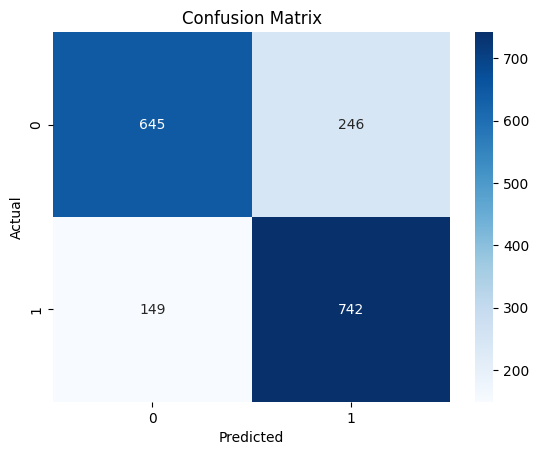

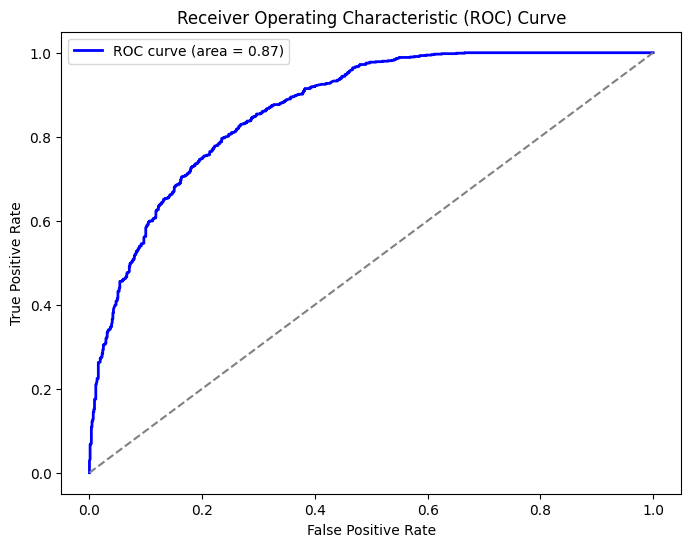

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()


# **Testing the Model on Realistic New Data**
We simulate a few conflict scenarios and pass them into the model to see how it predicts:



In [19]:
# Example: Test on 3 handcrafted "new" events
sample_inputs = pd.DataFrame({
    'COUNTRY': [5, 20, 12],        # Encoded countries (e.g., Nigeria, Sudan, etc.)
    'ADMIN1': [10, 4, 8],          # Encoded regions
    'EVENT_TYPE': [1, 3, 0],       # Violence, Battles, Protests, etc.
    'ACTOR1': [15, 6, 23],         # Encoded actors (e.g., police, militia)
    'LATITUDE': [0.55, 0.78, 0.42],# Normalized latitudes
    'LONGITUDE': [0.33, 0.61, 0.29],# Normalized longitudes
    'YEAR': [2024, 2023, 2025]     # Most recent years
})

# Predict with trained model
sample_preds = model.predict(sample_inputs)
sample_preds_proba = model.predict_proba(sample_inputs)

# Show predictions
for i, (pred, prob) in enumerate(zip(sample_preds, sample_preds_proba)):
    print(f"Sample {i+1}: Predicted RISK = {'HIGH' if pred == 1 else 'LOW'}, Probability = {prob[1]:.2f}")

Sample 1: Predicted RISK = HIGH, Probability = 0.51
Sample 2: Predicted RISK = LOW, Probability = 0.45
Sample 3: Predicted RISK = LOW, Probability = 0.37
